In [1]:
import pandas as pd
import numpy as np
import acessos as ac
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import os
import boto3

In [2]:
query = '''

select s.* 
, o.ds_cbo_group
, g.nr_score_bvs
, g.nr_score_serasa_custom
, g.ds_last_disapproval_reason
, gc.nr_institutions
, gc.nr_operations
, gc.vl_util_market
from customer_sandbox_zone.segmentacao_digital_credito_flavia_total s
left join customer_curated_zone.ca_dict_occupations o on (o.ds_occupation = s.ds_occupation)
left join growth_curated_zone.proposal_analysis g on (g.cpf = s.cpf)
left join customer_curated_zone.ca_book_gestao_carteira gc on (g.cpf = gc.cpf 
								and date_trunc('month', g.dt_cfi_account) = date_trunc('month', gc.dt_base_scr) )
order by rand()
limit 500000

'''

In [3]:
df = ac.df_athena('flavia-costa', query)

In [4]:
df.head()

,cpf,tempo_relacionamento,ds_risk_type,gender,nr_declared_income,vl_limite_cartao,ds_region,ds_occupation,nm_current_os,ds_city_size,...,gr_mobilidade,gr_pix,ds_perfil_conexao,ds_cbo_group,nr_score_bvs,nr_score_serasa_custom,ds_last_disapproval_reason,nr_institutions,nr_operations,vl_util_market
0,06384885409,28.0,3. Medio Risco,MALE,3500.00,NaN,Nordeste,Trabalhador(a) de Reparação e Manutenção,android,pequeno,...,A,A,Outros,"TRABALHADORES DOS SERVIÇOS, VENDEDORES DO COMÉ...",232.0,NaN,NAO ATINGIU SCORE BVS,NaN,NaN,NaN
1,09819343909,84.0,3. Medio Risco,FEMALE,3000.00,900.0,Sul,Vendedor(a),ios,pequeno,...,A,B,Comprador Digital Móvel,"TRABALHADORES DOS SERVIÇOS, VENDEDORES DO COMÉ...",529.0,NaN,NAO ATINGIU SCORE BVS,NaN,NaN,NaN
2,10128147423,930.0,2. Alto Risco,FEMALE,0.01,12300.0,Nordeste,AUTÔNOMO,android,pequeno,...,A,C,Outros,AUTÔNOMOS,662.0,NaN,None,NaN,NaN,NaN
3,05910902440,88.0,3. Medio Risco,MALE,1900.00,5890.0,Nordeste,Outros,android,pequeno,...,A,A,Outros,OUTROS,705.0,768.0,None,4.0,5.0,7064.0
4,15614375732,622.0,4. Baixo Risco,MALE,2500.00,NaN,Sudeste,Motorista,android,grande,...,A,A,Outros,"TRABALHADORES DOS SERVIÇOS, VENDEDORES DO COMÉ...",NaN,NaN,NEGATIVADO SERASA,NaN,NaN,NaN


In [5]:
# defining types
id_columns = ['cpf']
cat_columns = df.drop(id_columns, axis = 1).select_dtypes('string').columns
num_columns = df.drop(id_columns, axis = 1).select_dtypes(exclude=['string']).columns

#defining roles
preditores_dummie = ['gender',	'ds_region', 'ds_cbo_group', 'nm_current_os', 'ds_city_size', 'ds_schooling', 'ds_last_disapproval_reason'] 
target = ['ds_perfil_conexao']

In [6]:
df['ds_last_disapproval_reason'].fillna('ni', inplace = True)

In [7]:
for column in df.columns:
    if df[column].dtype == 'object':
        df[column].fillna(df[column].mode()[0], inplace = True)
    elif df[column].dtype == 'string':
        df[column].fillna(df[column].mode()[0], inplace = True)
    elif df[column].dtype != 'object':
        df[column].fillna(0.0, inplace = True)

In [36]:
df_model = pd.get_dummies(df, columns=preditores_dummie)

In [37]:
df_model['flag_digitais'] = np.where(df_model['ds_perfil_conexao'] == 'Outros', 0, 1)
df_model['flag_digitais'].value_counts()

0    390482
1    109518
Name: flag_digitais, dtype: int64

In [38]:
cols_analise = ['nr_score_bvs',
'nr_declared_income',
'vl_util_market',
'nr_score_serasa_custom',
'nr_institutions']

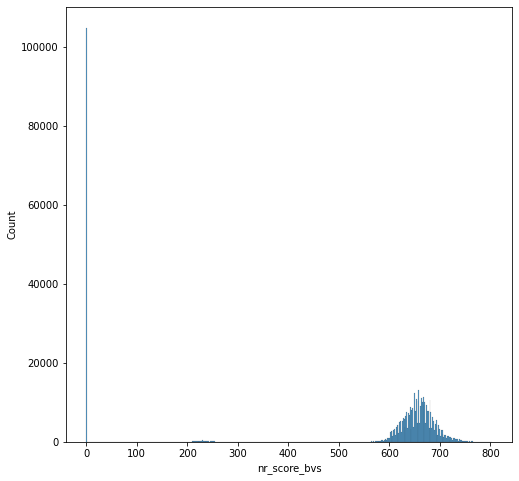

In [56]:
plt.figure(figsize = (8,8))
sns.histplot(data = df_model['nr_score_bvs'])
plt.show()

In [78]:
df_model['nr_score_bvs_fx'] = np.where(df_model['nr_score_bvs'] <= 300, '1.fx_ate300',
                              np.where((df_model['nr_score_bvs'] > 300) & (df_model['nr_score_bvs'] <= 600), '2.fx_>300-600',
                              np.where((df_model['nr_score_bvs'] > 600) & (df_model['nr_score_bvs'] <= 650), '3.fx_>600-650',
                              np.where((df_model['nr_score_bvs'] > 650) & (df_model['nr_score_bvs'] <= 700), '4.fx_>650-700', '5.fx_mais700'          
                                       ))))

df_model['nr_score_bvs_fx'].value_counts()

4.fx_>650-700    205572
3.fx_>600-650    141797
1.fx_ate300      111087
5.fx_mais700      31972
2.fx_>300-600      9572
Name: nr_score_bvs_fx, dtype: int64

In [79]:
df_model['nr_declared_income_fx'] = np.where(df_model['nr_declared_income'] == 0, '1.fx_zero',
                                np.where((df_model['nr_declared_income'] > 0) & (df_model['nr_declared_income'] <= 500), '2.fx_ate500',
                              np.where((df_model['nr_declared_income'] > 500) & (df_model['nr_declared_income'] <= 1000), '3.fx_>500-1000',
                              np.where((df_model['nr_declared_income'] > 1000) & (df_model['nr_declared_income'] <= 1500), '4.fx_>1000-1500',
                              np.where((df_model['nr_declared_income'] > 1500) & (df_model['nr_declared_income'] <= 2000), '5.fx_>1500-2000', 
                              np.where((df_model['nr_declared_income'] > 2000) & (df_model['nr_declared_income'] <= 2500), '6.fx_>2000-2500',
                                       '7.fx_mais2500'          
                                       ))))))

df_model['nr_declared_income_fx'].value_counts()

7.fx_mais2500      178829
2.fx_ate500        120899
5.fx_>1500-2000     75344
4.fx_>1000-1500     65508
6.fx_>2000-2500     44869
3.fx_>500-1000      14551
Name: nr_declared_income_fx, dtype: int64

In [61]:
df_model['vl_util_market'].describe()

count    500000.000000
mean       1390.598106
std        6914.538769
min           0.000000
25%           0.000000
50%           0.000000
75%         390.000000
max      905685.000000
Name: vl_util_market, dtype: float64

In [80]:
df_model['vl_util_market_fx'] = np.where(df_model['vl_util_market'] == 0, '1.fx_zero',
                                np.where((df_model['vl_util_market'] > 0) & (df_model['vl_util_market'] <= 390), '2.fx_ate390',
                              np.where((df_model['vl_util_market'] > 390) & (df_model['vl_util_market'] <= 1000), '3.fx_>390-1000',
                              np.where((df_model['vl_util_market'] > 1000), 'fx_mais1000', 'ni'         
                                       ))))

df_model['vl_util_market_fx'].value_counts()

1.fx_zero         354588
fx_mais1000        94312
3.fx_>390-1000     30588
2.fx_ate390        20512
Name: vl_util_market_fx, dtype: int64

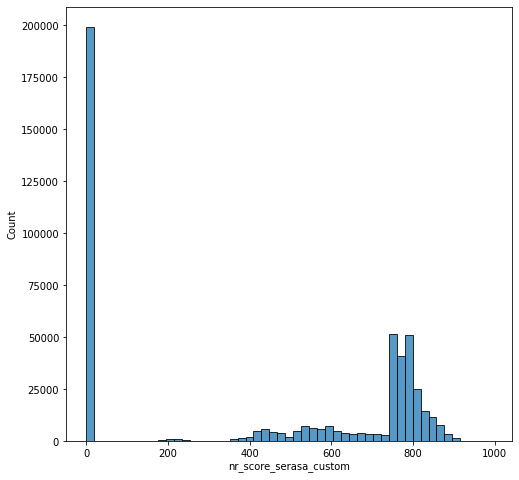

In [66]:
plt.figure(figsize = (8,8))
sns.histplot(data = df_model['nr_score_serasa_custom'])
plt.show()

In [81]:
df_model['nr_score_serasa_custom_fx'] = np.where(df_model['nr_score_serasa_custom'] == 0, '1.fx_zero',
                              np.where((df_model['nr_score_serasa_custom'] > 0) & (df_model['nr_score_serasa_custom'] <= 400), '2.fx_ate400',
                              np.where((df_model['nr_score_serasa_custom'] > 400) & (df_model['nr_score_serasa_custom'] <= 600), '3.fx_>400-600',
                              np.where((df_model['nr_score_serasa_custom'] > 600) & (df_model['nr_score_serasa_custom'] <= 700), '4.fx_>600-700', 
                              np.where((df_model['nr_score_serasa_custom'] > 700) & (df_model['nr_score_serasa_custom'] <= 800), '5.fx_>700-800',         
                              np.where((df_model['nr_score_serasa_custom'] > 800) & (df_model['nr_score_serasa_custom'] <= 1000), '6.fx_>800-1000', 
                                       '7.fx_mais1000'          
                                       ))))))

df_model['nr_score_serasa_custom_fx'].value_counts()

1.fx_zero         197367
5.fx_>700-800     153059
6.fx_>800-1000     62861
3.fx_>400-600      53857
4.fx_>600-700      21453
2.fx_ate400        11403
Name: nr_score_serasa_custom_fx, dtype: int64

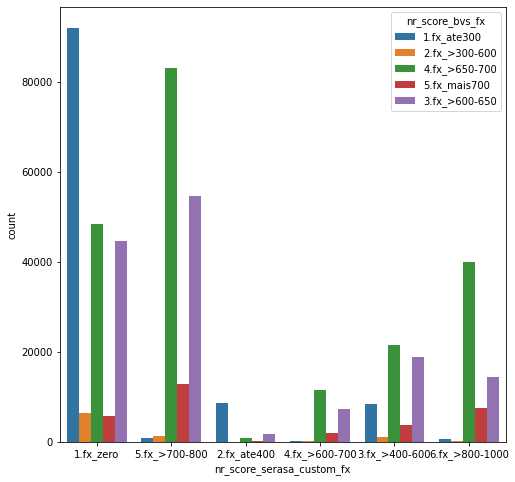

In [92]:
plt.figure(figsize = (8,8))
sns.countplot(data = df_model, x = 'nr_score_serasa_custom_fx', hue = 'nr_score_bvs_fx')
plt.show()

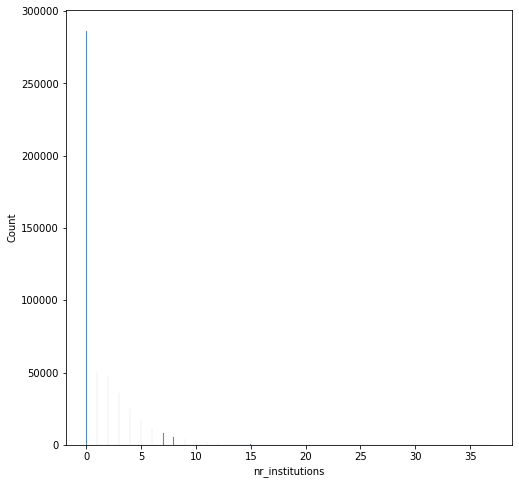

In [69]:
plt.figure(figsize = (8,8))
sns.histplot(data = df_model['nr_institutions'])
plt.show()

In [82]:
df_model['nr_institutions_fx'] = np.where(df_model['nr_institutions'] == 0, '1.fx_zero',
                              np.where((df_model['nr_institutions'] > 0) & (df_model['nr_institutions'] <= 2), '2.fx_ate2',
                              np.where((df_model['nr_institutions'] > 2) & (df_model['nr_institutions'] <= 4), '3.fx_>2-4',
                              np.where((df_model['nr_institutions'] > 4) & (df_model['nr_institutions'] <= 6), '4.fx_>4-6', 
                              np.where((df_model['nr_institutions'] > 6) & (df_model['nr_institutions'] <= 10), '5.fx_>6-10',         
                              np.where((df_model['nr_institutions'] > 10) , '6.fx_>10', 
                                       'ni'          
                                       ))))))

df_model['nr_institutions_fx'].value_counts()

1.fx_zero     286387
2.fx_ate2      98353
3.fx_>2-4      60254
4.fx_>4-6      28748
5.fx_>6-10     20367
6.fx_>10        5891
Name: nr_institutions_fx, dtype: int64

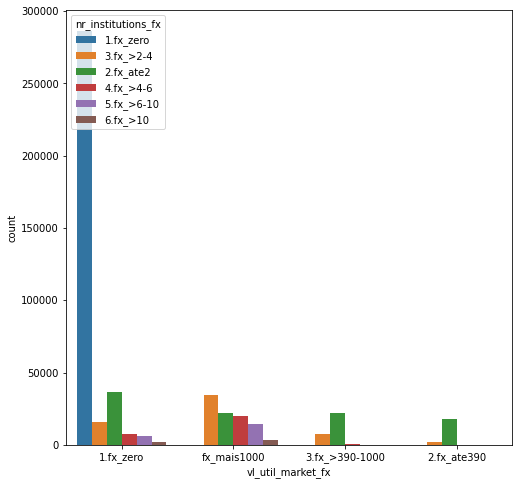

In [93]:
plt.figure(figsize = (8,8))
sns.countplot(data = df_model, x = 'vl_util_market_fx', hue = 'nr_institutions_fx')
plt.show()

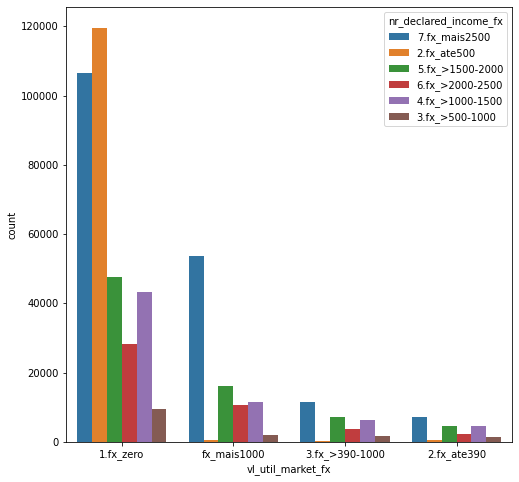

In [94]:
plt.figure(figsize = (8,8))
sns.countplot(data = df_model, x = 'vl_util_market_fx', hue = 'nr_declared_income_fx')
plt.show()

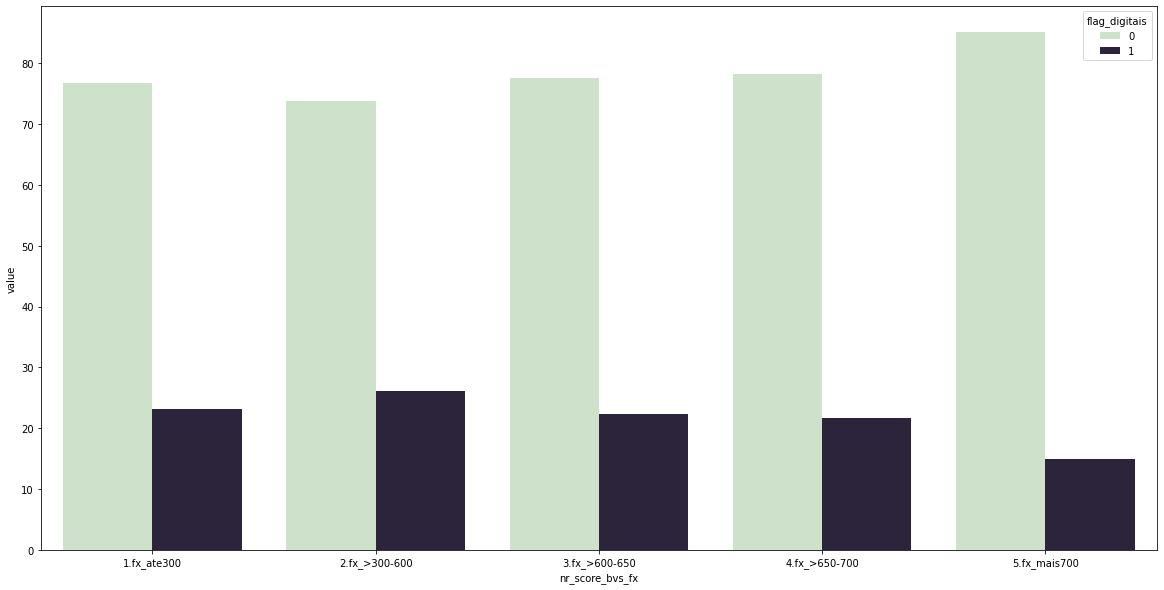

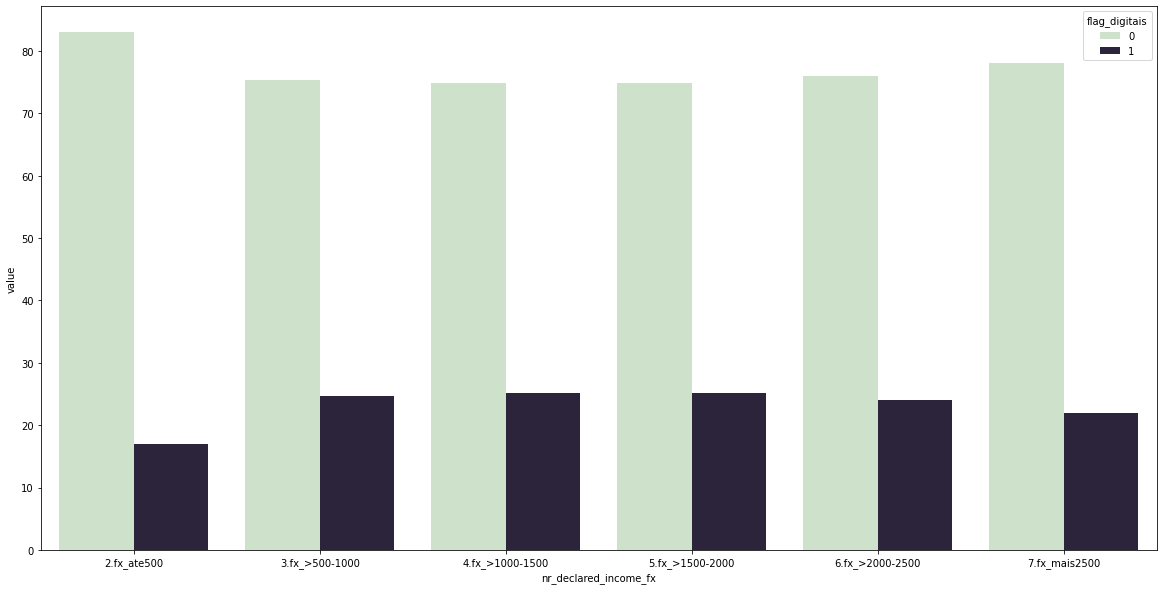

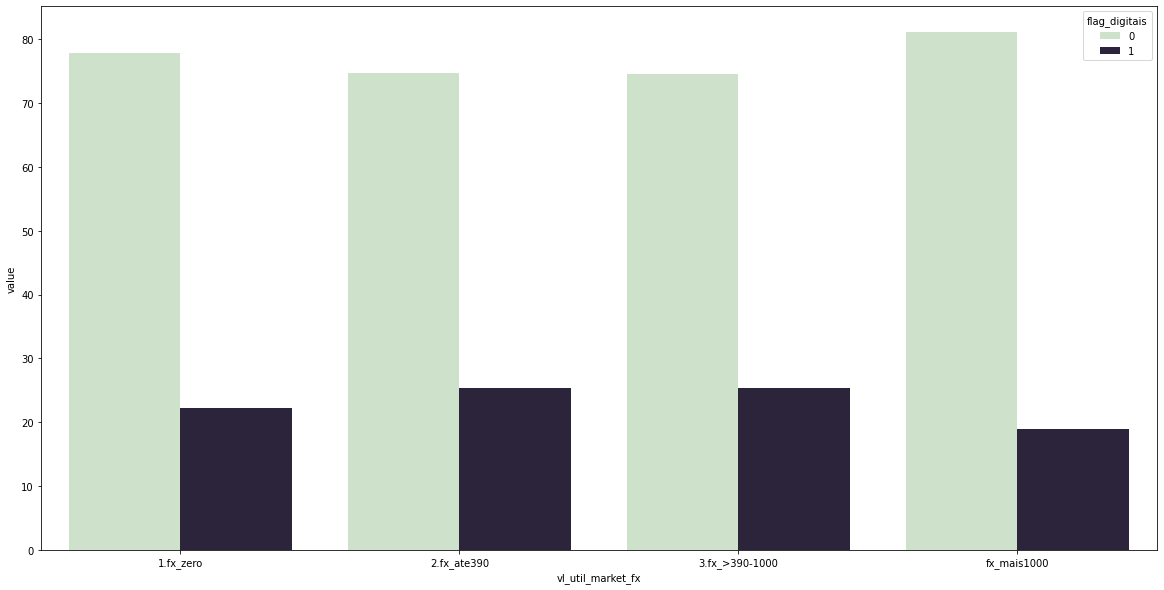

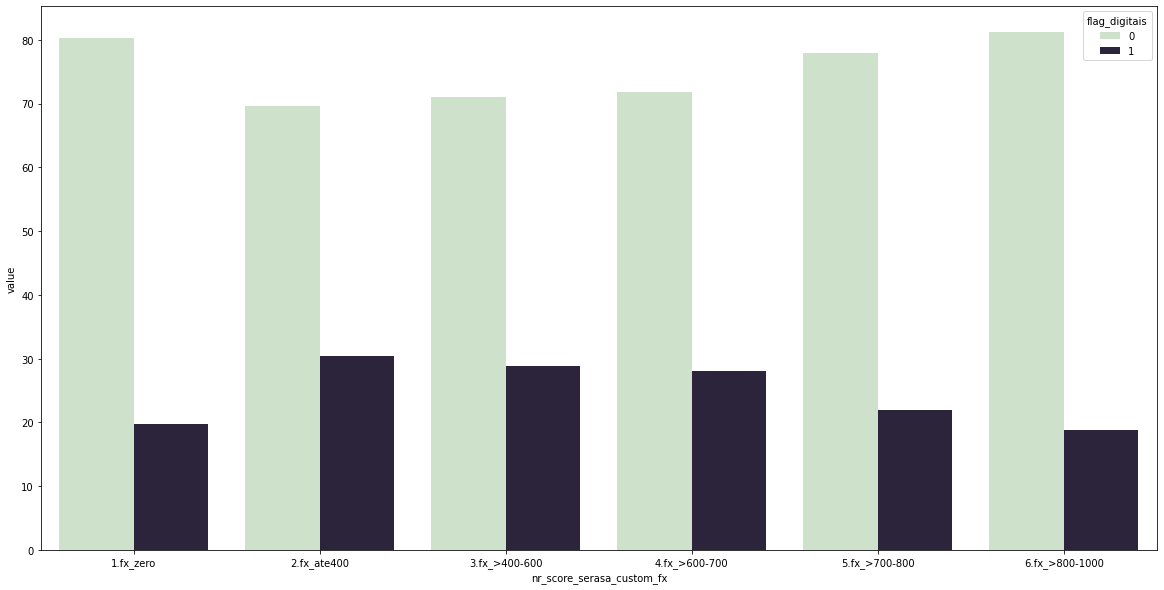

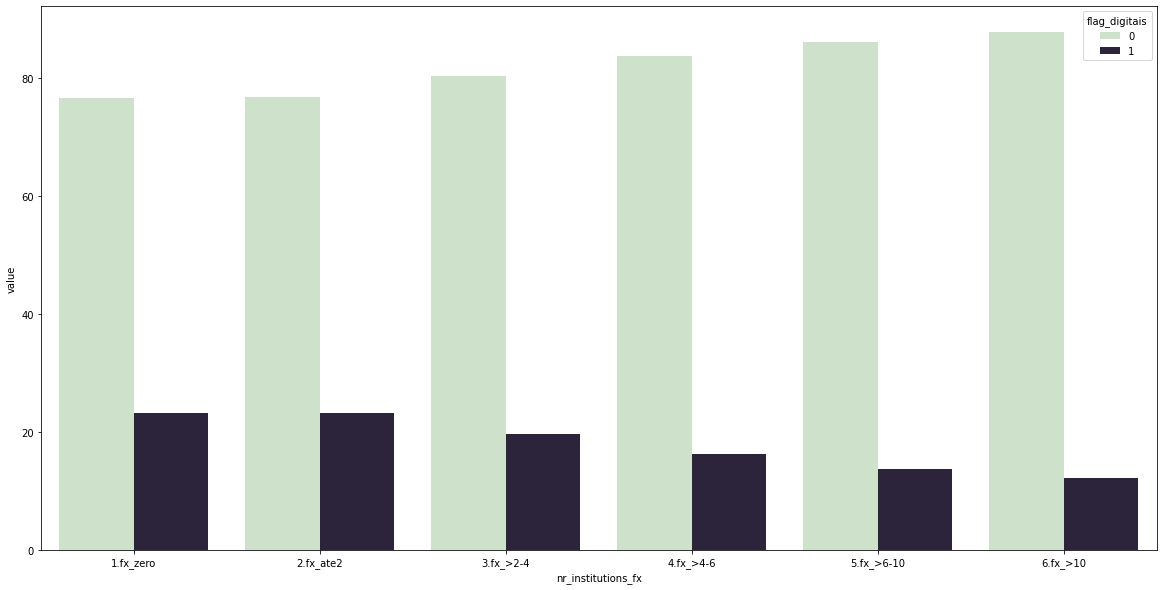

In [83]:

for i in cols_analise:
    group_var = 'flag_digitais' #vai estar na legenda
    x_var = f'{i}_fx'
    campo_contagem = 'count'
    agg = df_model.groupby([x_var, group_var]).agg({'cpf':['count']}) #alterar nome do dataframe e variavel de contagem
    agg.columns = agg.columns.droplevel(0)
    agg = agg.reset_index()
    df_viz = agg.pivot_table(columns=x_var,index = group_var, values=campo_contagem, aggfunc=np.sum)

    for i in df_viz.columns:
        df_viz[i] = df_viz[i] / df_viz[i].sum()

    df_viz = df_viz.reset_index()
    df_viz = pd.melt(df_viz, id_vars=[group_var])
    df_viz['value'] = df_viz['value'] * 100
    x = df_viz[x_var].astype('str')
    y = df_viz[group_var].astype('str')
    z = df_viz.value.round(1)
    plt.figure(figsize = (20,10))
    sns.barplot(data = df_viz, x = x, y = z, hue = y, palette="ch:s=1,rot=-2")
    plt.show()

In [84]:
preditores_dummie

['gender',
 'ds_region',
 'ds_cbo_group',
 'nm_current_os',
 'ds_city_size',
 'ds_schooling',
 'ds_last_disapproval_reason']

In [88]:
df['flag_digitais'] = np.where(df_model['ds_perfil_conexao'] == 'Outros', 0, 1)

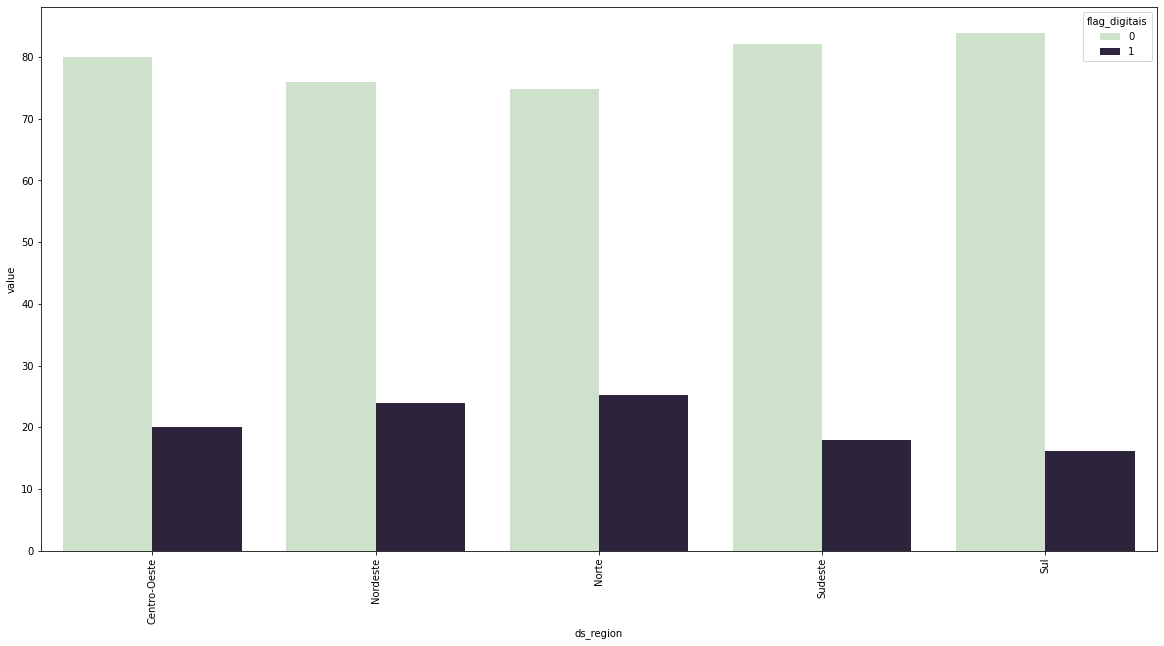

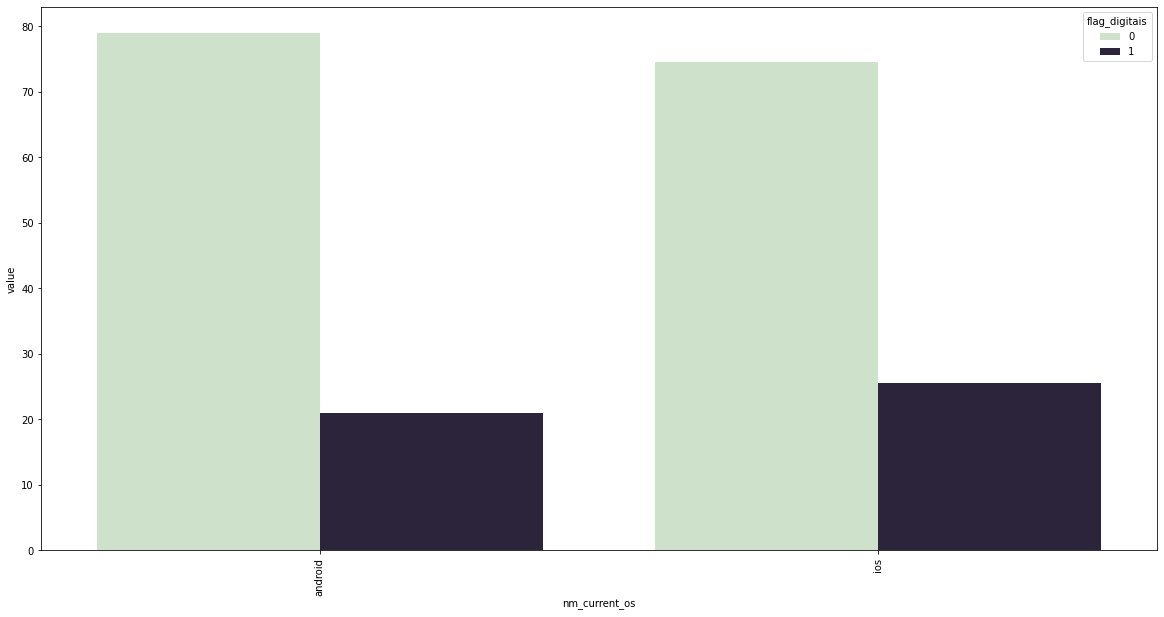

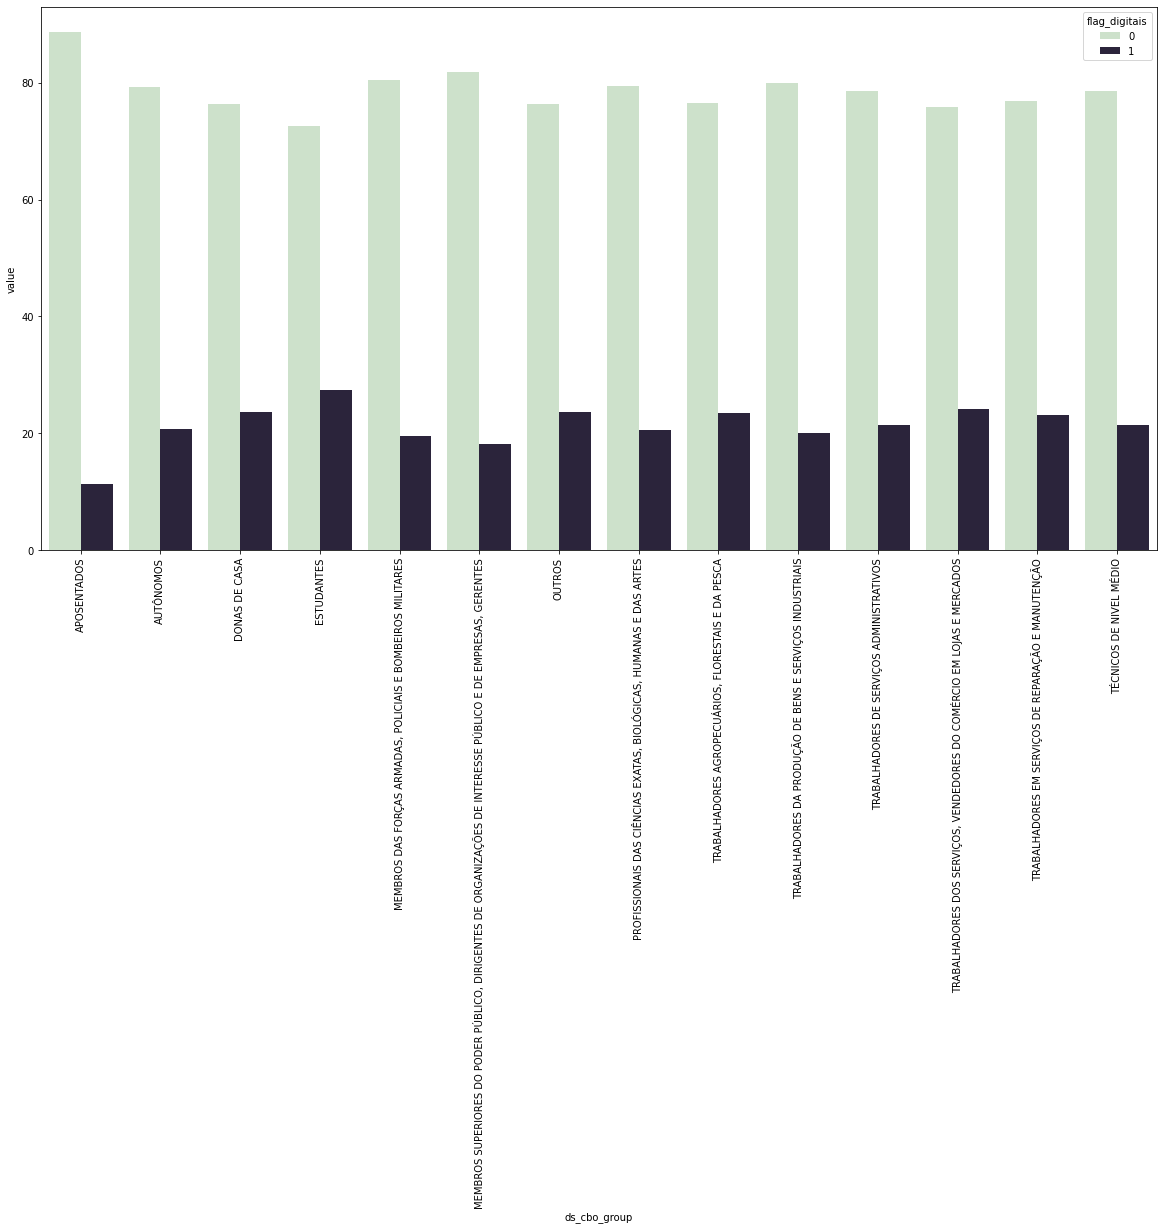

In [91]:
flags_analise = ['ds_region', 'nm_current_os', 'ds_cbo_group']

for i in flags_analise:
    group_var = 'flag_digitais' #vai estar na legenda
    x_var = i
    campo_contagem = 'count'
    agg = df.groupby([x_var, group_var]).agg({'cpf':['count']}) #alterar nome do dataframe e variavel de contagem
    agg.columns = agg.columns.droplevel(0)
    agg = agg.reset_index()
    df_viz = agg.pivot_table(columns=x_var,index = group_var, values=campo_contagem, aggfunc=np.sum)

    for i in df_viz.columns:
        df_viz[i] = df_viz[i] / df_viz[i].sum()

    df_viz = df_viz.reset_index()
    df_viz = pd.melt(df_viz, id_vars=[group_var])
    df_viz['value'] = df_viz['value'] * 100
    x = df_viz[x_var].astype('str')
    y = df_viz[group_var].astype('str')
    z = df_viz.value.round(1)
    plt.figure(figsize = (20,10))
    sns.barplot(data = df_viz, x = x, y = z, hue = y, palette="ch:s=1,rot=-2")
    plt.xticks(rotation=90)
    plt.show()

#### Teste segmentação

In [95]:
df['seg_bureau'] = np.where((df.nr_score_bvs <= 700) | ((df.nr_score_serasa_custom > 400) & (df.nr_score_serasa_custom <= 700)), 'A', 'B')

df['seg_bureau'].value_counts()

A    473733
B     26267
Name: seg_bureau, dtype: int64

In [96]:
df['seg_renda_vl_mercado'] = np.where(((df.vl_util_market <= 1000) & (df.nr_declared_income > 500)), 'A', 'B')

df['seg_renda_vl_mercado'].value_counts()

A    285293
B    214707
Name: seg_renda_vl_mercado, dtype: int64

In [97]:
df['seg_estados'] = np.where(((df.ds_region == 'Norte') | (df.ds_region == 'Nordeste')), 'A', 'B')

df['seg_estados'].value_counts()

A    318971
B    181029
Name: seg_estados, dtype: int64

In [99]:
df['seg_prof'] = np.where((df.ds_cbo_group != 'APOSENTADOS' ), 'A', 'B')

df['seg_prof'].value_counts()

A    490543
B      9457
Name: seg_prof, dtype: int64

In [100]:
df['seg_os'] = np.where((df.nm_current_os != 'android' ), 'A', 'B')

df['seg_os'].value_counts()

B    395815
A    104185
Name: seg_os, dtype: int64

In [101]:
df['segmentation'] = df['seg_bureau'] + df['seg_renda_vl_mercado'] + df['seg_estados'] + df['seg_prof'] + df['seg_os'] 

df['segmentation'].value_counts()

AAAAB    144438
ABAAB     93461
AABAB     68073
ABBAB     60172
AAAAA     34076
ABAAA     24617
AABAA     21731
ABBAA     19870
BAAAB      7141
BBAAB      6697
BBBAB      3937
BABAB      3343
AAABB      2798
ABABB      2032
BBAAA       945
AABBB       926
ABBBB       871
BBBAA       768
BAABB       763
BAAAA       747
BBABB       636
BABAA       527
BBBBB       279
AAABA       266
BABBB       248
ABABA       198
AABBA       109
ABBBA        95
BBABA        81
BAABA        75
BBBBA        48
BABBA        32
Name: segmentation, dtype: int64

In [102]:
#optimal binning
from optbinning import OptimalBinning
from optbinning import BinningProcess
from sklearn.metrics import classification_report

(CVXPY) Oct 30 04:28:13 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Oct 30 04:28:13 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


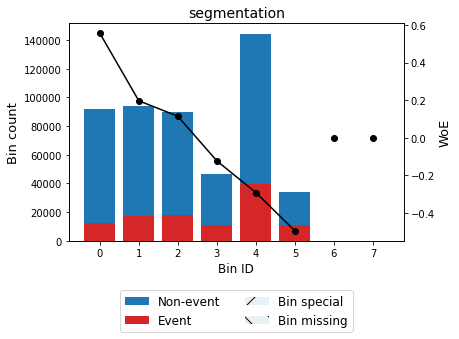

In [104]:
binning_process = BinningProcess(variable_names=list(['segmentation']))
binning_process.fit(df[['segmentation']], df['flag_digitais'])

optb = binning_process.get_binned_variable(name='segmentation')
optb.binning_table.plot()

In [105]:
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[BABBB, BBBBB, AABBB, ABBBB, BABBA, BAABB, BBA...",91530,0.183060,78847,12683,0.138567,0.555954,0.047876,0.005909
1,"[ABABA, ABAAB, BBBBA]",93707,0.187414,76161,17546,0.187243,0.196731,0.006853,0.000855
2,"[ABBAA, AABAB, BBAAA, BAAAA]",89635,0.179270,71700,17935,0.200089,0.114444,0.002272,0.000284
3,"[AAABA, AABAA, ABAAA]",46614,0.093228,35393,11221,0.240722,-0.122566,0.001449,0.000181
4,[AAAAB],144438,0.288876,105037,39401,0.272788,-0.290771,0.026395,0.003288
5,[AAAAA],34076,0.068152,23344,10732,0.314943,-0.494183,0.018883,0.002337
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,500000,1.000000,390482,109518,0.219036,,0.103727,0.012853


In [106]:
df['target_regra'] = np.where(df['segmentation'] == 'AAAAA', 1, 0)

In [107]:
print(classification_report(df['flag_digitais'], df['target_regra']))

              precision    recall  f1-score   support

           0       0.79      0.94      0.86    390482
           1       0.31      0.10      0.15    109518

    accuracy                           0.76    500000
   macro avg       0.55      0.52      0.50    500000
weighted avg       0.68      0.76      0.70    500000



In [108]:
df['target_regra'] = np.where(np.isin(df['segmentation'],['AAAAA','AAAAB']), 1, 0)

print(classification_report(df['flag_digitais'], df['target_regra']))

              precision    recall  f1-score   support

           0       0.82      0.67      0.74    390482
           1       0.28      0.46      0.35    109518

    accuracy                           0.62    500000
   macro avg       0.55      0.56      0.54    500000
weighted avg       0.70      0.62      0.65    500000

